# "Transfer Learning with TensorFlow : Feature Extraction"
> "Notebook demonstrates Transfer Learning using Feature Extraction in TensorFlow"

- toc: true
- badges: true
- comments: true
- categories: [Deep Learning, NeuralNetworks, TensorFlow, Transfer-Learning, Feature-Extraction]
- image: images/efficientnet.png

## Transfer Learning with TensorFlow : Feature Extraction  
> This Notebook is an account of my working for the Udemy course : [TensorFlow Developer Certificate in 2022: Zero to Mastery](https://www.udemy.com/course/tensorflow-developer-certificate-machine-learning-zero-to-mastery/).

Transfer learning is a machine learning method where a model developed for a task is reused as the starting point for a model on a second task.

It is a popular approach in deep learning where pre-trained models are used as the starting point on computer vision and natural language processing tasks given the vast compute and time resources required to develop neural network models on these problems and from the huge jumps in skill that they provide on related problems.

Concepts covered in this Notebook:  
* Introduce transfer learning with TensorFlow
* Using a small dataset to experiment faster(10% of training samples)
* Building a transfer learning feature extraction model with TensorFlow Hub.
* Use TensorBoard to track modelling experiments and results

**Why use transfer learning?**  

* Can leverage an existing neural network architecture **proven to work** on problems similar to our own
* Can leverage a working network architecture which has **already learned patterns** on similar data to our own (often results in great ML products with less data)


Example of tranfer learning use cases:  
* Computer Vision (using ImageNet for our Image classification problems)
* Natural Language Processing (detecting spam mails - spam filter)

### Downloading and getting familiar with data


In [1]:
# Get data (10% of 10 food classes from food101 dataset from kaggle)
import zipfile

# Download the data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

# Unzip the downloaded file
zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip")
zip_ref.extractall()
zip_ref.close()


--2022-02-18 07:42:56--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.5.128, 74.125.133.128, 74.125.140.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.5.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M  60.3MB/s    in 2.7s    

2022-02-18 07:42:59 (60.3 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [2]:
# How many images in each folder
import os
 
# Walk through 10 percent data dir and list number of files
for dirpath, dirnames, filenames in os.walk("10_food_classes_10_percent)"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

### Creating data loader (preparing the data)  

We'll use the `ImageDataGenerator` class to load in our images in batches.


In [3]:
# Setup data inputs
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE = (224,224)
BATCH_SIZE = 32

train_dir = "10_food_classes_10_percent/train"
test_dir = "10_food_classes_10_percent/test"

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale = 1/255.)

print("Training images:")
train_data_10_percent = train_datagen.flow_from_directory(train_dir,
                                                          target_size = IMAGE_SHAPE,
                                                          batch_size = BATCH_SIZE,
                                                          class_mode = "categorical")

print("Testing Images:")
test_data = test_datagen.flow_from_directory(test_dir,
                                             target_size = IMAGE_SHAPE,
                                             batch_size = 32,
                                             class_mode ="categorical")

Training images:
Found 750 images belonging to 10 classes.
Testing Images:
Found 2500 images belonging to 10 classes.


### Setting up callbacks (things to run whilst our model trains)

Callbacks are extra functionality you can add to your models to be performed during or after training. Some of the most popular callbacks:  

* Tracking experiments with the `TensorBoard` callback  
* Model checkpoint with the `ModelCheckpoint` callback
* Stopping a model from training (before it trains too long and overfits) with the `EarlyStopping` callback  

Some popular callbacks include:    

| Callback name | Use case | Code |
| --- | --- | --- |
| TensorBoard | Log the performance of multiple models and then view and compare these models in a visual way on TensorBoard (a dashboard for inspecting neural network parameters). Helpful to compare the results of different models on your data | `tf.keras.callbacks.TensorBoard()` |
| Model checkpointing | Save your model as it trains so you can stop training if needed and come back to continue off where you left. Helpful if training takes a long time and can't be done in one sitting | `tf.keras.callbacks.ModelCheckpoint()` |
| Early Stopping | Leave your model training for an arbitary amount of time and have it stop training automatically when it ceases to improve. Helpful when you've got a large dataset and don't know how long training will take | `tf.keras.callbacks.EarlyStopping()`

In [4]:
# Create TensorBoard callback (functionized because we need to create a new one for each model)
import datetime
import tensorflow as tf

def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = log_dir)
  print(f"Saving TensorBoard log files to : {log_dir}")
  return tensorboard_callback


> **Note:**  You can customize the directory where your TensorBoard logs (model training metrics) get saved to whatever you like. The `log_dir` parameter we've created above is only one option.

### Creating models using Tensorflow Hub  

TensorFlow Hub is the repository of pre-trained machine learning models created with tensorflow.  

We are going to do a similar process, except the majority of our model's layers are going to come from TensorFlow Hub.

[TensorFlow Hub](https://www.tensorflow.org/hub)

In [5]:
# Let's compare the following two models
efficientnet_url = "https://tfhub.dev/google/efficientnet/b0/classification/1"

resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5"

In [6]:
# Import dependencies
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

In [7]:
# Let's make a create_model() function to  create a model from a URL
def create_model(model_url, num_classes = 10):
  """
  Takes a TensorFlow Hub URL and creates a Keras Sequential model with it

  Args:
    model_url(str): A TensorFlow Hub features extraction URL.
    num_classes(int) : Number of output neurons in the output layer,
      should be equal to number of target classes, default 10.

  Returns:
    An uncompiled Keras Sequential model with model_url as feature extractor
    layers and Dense output layers with num_classes output neurons.
  """
  # Download the pretrained model and save it 
  feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable =False,
                                           name = "feature_extraction_layer",
                                           input_shape = IMAGE_SHAPE+(3,)) # Freeze the already learned parameters

  # Create our model
  model = tf.keras.Sequential([
     feature_extractor_layer,
     layers.Dense(num_classes, activation = "softmax", name = "output_layer")                               
  ])      

  return model                                  
  

### Creating and testing ResNet TensorFlow Hub Feature Extraction model

In [8]:
# Create Resnet model
resnet_model = create_model(resnet_url,
                            num_classes=train_data_10_percent.num_classes)

In [9]:
resnet_model.compile(loss = "categorical_crossentropy",
                     optimizer = tf.keras.optimizers.Adam(),
                     metrics = ["accuracy"])

In [10]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 2048)             23564800  
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


whoaa..the number of parameters are ~23 Million. But only ~20,000 are trainable parameters other are from the freeze model we uploaded from the tensorflow hub. Here's look at the Resnet50 architecture:  

![](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/04-resnet-feature-extractor.png)
*What our current model looks like. A ResNet50V2 backbone with a custom dense layer on top (10 classes instead of 1000 ImageNet classes). **Note:** The Image shows ResNet34 instead of ResNet50. **Image source:** https://arxiv.org/abs/1512.03385.*


In [11]:
# Fit the resnet model to our 10% of the data 
resnet_history = resnet_model.fit(train_data_10_percent,
                 epochs = 5,
                 steps_per_epoch =len(train_data_10_percent),
                 validation_data = test_data,
                 validation_steps = len(test_data),
                 callbacks = [create_tensorboard_callback(dir_name="tensorflow_hub",
                                                          experiment_name ="resnet50V2")])

Saving TensorBoard log files to : tensorflow_hub/resnet50V2/20220218-074315
Epoch 1/5
24/24 [==============================] - 39s 1s/step - loss: 1.9621 - accuracy: 0.3333 - val_loss: 1.2971 - val_accuracy: 0.5844
Epoch 2/5
24/24 [==============================] - 26s 1s/step - loss: 0.9486 - accuracy: 0.7053 - val_loss: 0.8931 - val_accuracy: 0.7084
Epoch 3/5
24/24 [==============================] - 26s 1s/step - loss: 0.6548 - accuracy: 0.8067 - val_loss: 0.7746 - val_accuracy: 0.7440
Epoch 4/5
24/24 [==============================] - 21s 905ms/step - loss: 0.5017 - accuracy: 0.8707 - val_loss: 0.7280 - val_accuracy: 0.7560
Epoch 5/5
24/24 [==============================] - 21s 908ms/step - loss: 0.4017 - accuracy: 0.9133 - val_loss: 0.6811 - val_accuracy: 0.7732


Our transfer learning feature extractor model outperformed all of the previous models we built by hand. We have achieved around ~91% accuracy!! with only 10% of the data. we have a validation accuracy ~77%

In [17]:
# let's create a function to plot our loss curves
# we can put a function like this into a script called "helper.py and import "
import matplotlib.pyplot as plt
plt.style.use('dark_background') # set dark background for plots

def plot_loss_curves(history):
  """
  Returns training and validation metrics

  Args: 
    history : TensorFlow History object.

  Returns:
    plots of training/validation loss and accuracy metrics

  """
  
  loss = history.history["loss"]
  val_loss = history.history["val_loss"] 

  accuracy = history.history["accuracy"]
  val_accuracy = history.history["val_accuracy"]

  epochs = range(len(history.history["loss"]))

  # Plot loss
  plt.plot(epochs, loss, label = "training_loss")
  plt.plot(epochs, val_loss, label = "validation_loss")
  plt.title("Loss")
  plt.xlabel("Epochs")
  plt.legend()

  # Plot Accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label ="training_accuracy")
  plt.plot(epochs, val_accuracy, label = "validation_accuracy")
  plt.title("Accuracy")
  plt.xlabel("Accuracy")
  plt.legend();

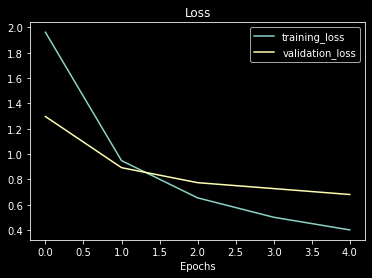

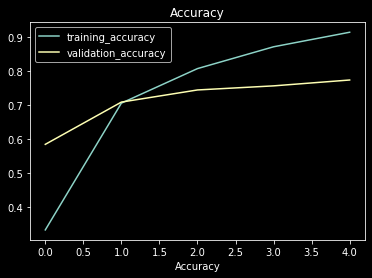

In [18]:
plot_loss_curves(resnet_history)

### Creating and testing EfficientNetB0 TensorFlow Hub Feature Extraction model

In [19]:
# Create Efficient model
efficientnet_model = create_model(model_url=efficientnet_url,
                            num_classes=train_data_10_percent.num_classes)

# Compile the EfficientNet model
efficientnet_model.compile(loss = "categorical_crossentropy",
                           optimizer = tf.keras.optimizers.Adam(),
                           metrics = ["accuracy"])

# Fit EfficientNet model to 10% of training data
efficientnet_history = efficientnet_model.fit(train_data_10_percent,
                                              epochs =5,
                                              steps_per_epoch =len(train_data_10_percent),
                                              validation_data = test_data,
                                              validation_steps = len(test_data),
                                              callbacks = [create_tensorboard_callback(dir_name ="tensorflow_hub",
                                                                                       experiment_name="efficientnetb0")])

Saving TensorBoard log files to : tensorflow_hub/efficientnetb0/20220218-075921
Epoch 1/5
24/24 [==============================] - 26s 902ms/step - loss: 1.8412 - accuracy: 0.4000 - val_loss: 0.9458 - val_accuracy: 0.7020
Epoch 2/5
24/24 [==============================] - 19s 820ms/step - loss: 0.7660 - accuracy: 0.7600 - val_loss: 0.6298 - val_accuracy: 0.7928
Epoch 3/5
24/24 [==============================] - 20s 847ms/step - loss: 0.5194 - accuracy: 0.8480 - val_loss: 0.5491 - val_accuracy: 0.8240
Epoch 4/5
24/24 [==============================] - 19s 836ms/step - loss: 0.3962 - accuracy: 0.8907 - val_loss: 0.5118 - val_accuracy: 0.8316
Epoch 5/5
24/24 [==============================] - 19s 834ms/step - loss: 0.3268 - accuracy: 0.9187 - val_loss: 0.4939 - val_accuracy: 0.8420


We have done really well with EfficientNetb0 model. we have training accuracy ~91% and validation accuracy ~84%.

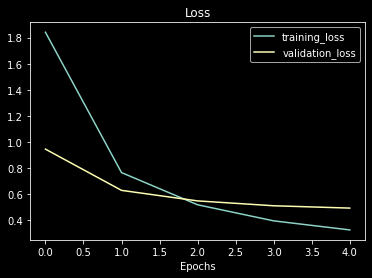

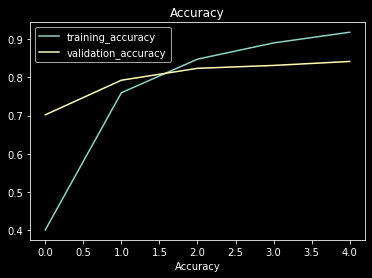

In [20]:
# Let's plot the loss curves
plot_loss_curves(efficientnet_history)

In [21]:
efficientnet_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 1000)             5330564   
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                10010     
                                                                 
Total params: 5,340,574
Trainable params: 10,010
Non-trainable params: 5,330,564
_________________________________________________________________


In [22]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 2048)             23564800  
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


The EfficientNet architecture performs really good even though the number of parameters in the model are far less than ResNet model. 

In [26]:
len(efficientnet_model.layers[0].weights)

311

our Neural network learns these weights/parameters for extracting and generalizing features for better prediction on new data

### Different types of transfer learning  

* **"As is" transfer learning** - using an existing model with no changes(eg. using ImageNet model on 1000 ImageNet classes, none of your own)  
* **"Feature extraction"** transfer learning - use the pre-learned patterns of an existing model (eg. EffiientNetB0 trained on ImageNet) and adjust the output layer for your own problem(eg. 1000 classes -> 10 classes of food)  
* **"Fine tuning" transfer learning** - use the prelearned patterns of an existing model and "fine-tune" many or all of the underlying layers(including new output layers)  

![](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/04-different-kinds-of-transfer-learning.png)
*The different kinds of transfer learning. An original model, a feature extraction model (only top 2-3 layers change) and a fine-tuning model (many or all of original model get changed).*

### Comparing our model's results using TensorBoard  

**What is TensorBoard?**  
* A way to visually explore your machine learning models performance and internals.  
* Host, track and share your machine learning experiments on [TensorBoard.dev](https://tensorboard.dev/)  

> **Note:** When you upload things to TensorBoard.dev, your experiments are public. So, if you're running private experiments (things you don't want other to see) do not upload them to TensorBoard.dev

In [ ]:
# Run thie code  cell for uploading the experiment to TensorBoard
# Upload TensorBoard dev records
!tensorboard dev upload --logdir ./tensorflow_hub/ \
  --name "EfficientNetB0 vs. ResNet50V2" \
  --description "Comparing two different TF Hub Feature extraction model architectures using 10% of the training data" \
  --one_shot

In [28]:
#Check out what TensorBoard experiments you have
!tensorboard dev list

https://tensorboard.dev/experiment/1OBT56EnQ7GbJSOdsOKjZg/
	Name                 EfficientNetB0 vs. ResNet50V2
	Description          Comparing two different TF Hub Feature extraction model architectures using 10% of the training data
	Id                   1OBT56EnQ7GbJSOdsOKjZg
	Created              2022-02-18 08:32:35 (5 minutes ago)
	Updated              2022-02-18 08:32:38 (5 minutes ago)
	Runs                 4
	Tags                 5
	Scalars              60
	Tensor bytes         0
	Binary object bytes  3145194
Total: 1 experiment(s)


In [ ]:
# Delete an experiment 
# !tensorboard dev delete --experiment_id [copy your id here]

Weights&Biases also integreates with TensorFlow so we can use that as visualization tool.

## References:  

* [weights&bisases](https://wandb.ai/site)
* [TensorBoard experiment](https://tensorboard.dev/experiment/1OBT56EnQ7GbJSOdsOKjZg/)
* [TensorFlow Developer Certificate in 2022: Zero to Mastery](https://www.udemy.com/course/tensorflow-developer-certificate-machine-learning-zero-to-mastery/)